In [1]:
from sgp4.api import Satrec
from astropy.coordinates import *
from astropy import units as u
from astropy.time import Time
import numpy as np  
import matplotlib.pyplot as plt

from pathlib import Path
import sys

Reading NORAD measures (see bottom for file copypaste).

In [2]:
def parse_tle_file(file_content):
    lines = file_content.strip().split('\n')
    result = {}
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if "OBJECT" in line:
            object_name = line.strip()
            if i + 2 < len(lines):
                line1 = lines[i + 1].strip()
                line2 = lines[i + 2].strip()
                result[object_name] = (line1, line2)
                i += 3
            else:
                break
        else:
            i += 1
    
    return result

FILEPATH = Path("/Users/peppedilillo/Desktop/tle_check/norad.txt")
with open(FILEPATH, 'r') as file:
    content = file.read()

tle_data = parse_tle_file(content)

Reading HERMES data

In [3]:
H1_TREF = "2025-03-28 20:54:50"

H1 = (
    np.array((-3264.3768, 219.0079, 5902.4429)), # km 
    np.array((-6.1285, 2.3917, -3.4702)), # km / s
)

H1_ERR = (
    np.array((1157.8453, 450.0390, 676.9687)) / 1000, # km
    np.array((0.7632, .0869, 1.3567)) / 1000, # km / s
)

H2_TREF = "2025-03-28 22:30:30"

H2 = (
    np.array((-5756.2715, 1337.4833, 3359.0302)),
    np.array((-3.3279, 1.9151, -6.4542)),
)

H2_ERR = (
    np.array((498.6868, 282.0342, 951.8004)) / 1000, # km
    np.array((1.0324, 0.2415, 0.6182)) / 1000, # km / s
)

Propagate to H1.

In [4]:
tref = Time(H1_TREF, format='iso')

propagated = {}
for satname in tle_data:
    sat = Satrec.twoline2rv(*tle_data[satname])
    e, r, v = sat.sgp4(tref.jd1, tref.jd2)
    if e: 
        raise RuntimError("SGPT4 encountered an error")
    propagated[satname] = (np.array(r), np.array(v))

Compute displacements for H1.

In [5]:
diffs = {}
for satname in propagated:
    dr_sigma = np.linalg.norm(H1[0] -  propagated[satname][0]) #/ np.linalg.norm(H1_ERR[0])
    dv_sigma = np.linalg.norm(H1[1] -  propagated[satname][1]) #/ np.linalg.norm(H1_ERR[1])
    diffs[satname] = (dr_sigma, dv_sigma)

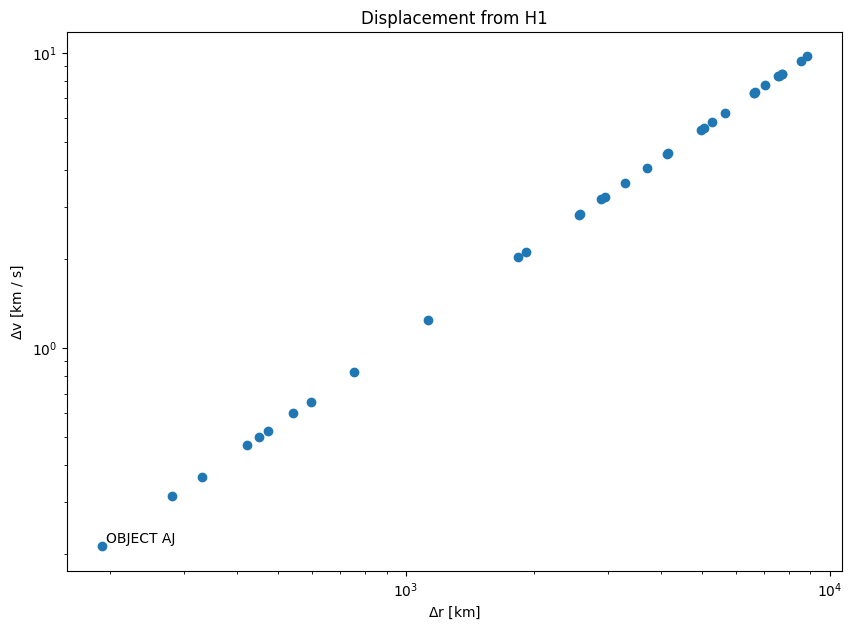

In [6]:
xs, ys = zip(*[(dr, dv) for dr, dv in diffs.values()])
names = [*tle_data.keys()]

fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(x=xs, y=ys)
for i in range(1):
    index = np.argsort(xs)[i]
    name = names[index]
    x = xs[index]
    y = ys[index]
    plt.annotate(name, (x, y), xytext=(3, 3), size=10, textcoords='offset points')
plt.xlabel("$\\Delta$r [km]")
plt.ylabel("$\\Delta$v [km / s]")
plt.title("Displacement from H1")
plt.loglog()
plt.show()

Propagate to H2.

In [7]:
tref = Time(H2_TREF, format='iso')

propagated = {}
for satname in tle_data:
    sat = Satrec.twoline2rv(*tle_data[satname])
    e, r, v = sat.sgp4(tref.jd1, tref.jd2)
    if e: 
        raise RuntimError("SGPT4 encountered an error")
    propagated[satname] = (np.array(r), np.array(v))

Compute displacements for H2.

In [8]:
diffs = {}
for satname in propagated:
    dr_sigma = np.linalg.norm(H2[0] -  propagated[satname][0]) #/ np.linalg.norm(H1_ERR[0])
    dv_sigma = np.linalg.norm(H2[1] -  propagated[satname][1]) #/ np.linalg.norm(H1_ERR[1])
    diffs[satname] = (dr_sigma, dv_sigma)

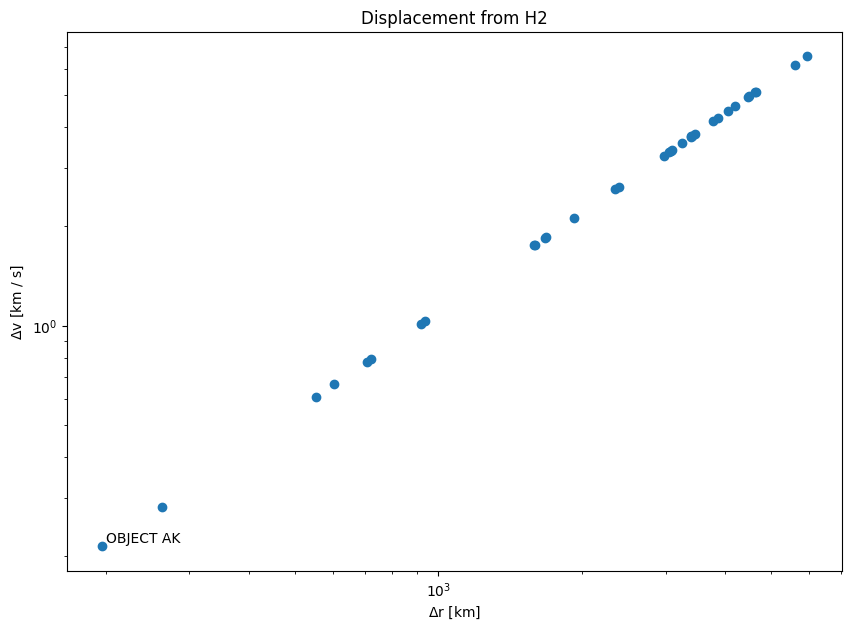

In [9]:
xs, ys = zip(*[(dr, dv) for dr, dv in diffs.values()])
names = [*tle_data.keys()]

fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(x=xs, y=ys)
for i in range(1):
    index = np.argsort(xs)[i]
    name = names[index]
    x = xs[index]
    y = ys[index]
    plt.annotate(name, (x, y), xytext=(3, 3), size=10, textcoords='offset points')
plt.xlabel("$\\Delta$r [km]")
plt.ylabel("$\\Delta$v [km / s]")
plt.title("Displacement from H2")
plt.loglog()
plt.show()

-----

### `norad.txt`


```
# norad.txt
OBJECT A                
1 63210U 25052A   25087.96689845  .00021501  00000+0  10484-2 0  9990
2 63210  97.4514 343.0843 0003651 185.7358 174.3835 15.18329538  2223
OBJECT B                
1 63211U 25052B   25087.96746428  .00023743  00000+0  11578-2 0  9997
2 63211  97.4506 343.0823 0003415 191.4994 168.6162 15.18308364  2224
OBJECT C                
1 63212U 25052C   25087.96928611  .00051519  00000+0  25130-2 0  9995
2 63212  97.4373 343.0617 0000561 202.3108 157.8101 15.18116377  2220
OBJECT D                
1 63213U 25052D   25087.96906182  .00022846  00000+0  11206-2 0  9995
2 63213  97.4422 343.0681 0001981 204.6608 155.4532 15.18113908  2223
OBJECT E                
1 63214U 25052E   25087.96908011  .00022708  00000+0  11140-2 0  9993
2 63214  97.4422 343.0682 0001980 204.5351 155.5789 15.18110451  2223
OBJECT F                
1 63215U 25052F   25087.96934095  .00022693  00000+0  11145-2 0  9993
2 63215  97.4423 343.0680 0001981 206.0870 154.0265 15.18072349  2223
OBJECT G                
1 63216U 25052G   25087.97030499  .00018652  00000+0  92188-3 0  9997
2 63216  97.4381 343.0607 0001086 226.8543 133.2600 15.17891202  2227
OBJECT H                
1 63217U 25052H   25087.64134876  .00022067  00000+0  10899-2 0  9999
2 63217  97.4398 342.7384 0001687 239.0329 121.0739 15.17879718  2179
OBJECT J                
1 63218U 25052J   25087.64142538  .00021862  00000+0  10801-2 0  9999
2 63218  97.4399 342.7384 0001709 240.0340 120.0725 15.17871481  2174
OBJECT K                
1 63219U 25052K   25087.97105014  .00022656  00000+0  11186-2 0  9993
2 63219  97.4400 343.0623 0001758 237.1099 122.9966 15.17887115  2225
OBJECT L                
1 63220U 25052L   25087.97270008  .00011543  00000+0  57867-3 0  9991
2 63220  97.4476 343.0717 0003042 227.4425 132.6552 15.17503257  2228
OBJECT M                
1 63221U 25052M   25087.97336282  .00008633  00000+0  43535-3 0  9992
2 63221  97.4397 343.0586 0001936 246.1868 113.9162 15.17378773  2226
OBJECT N                
1 63222U 25052N   25087.97387460  .00011903  00000+0  59868-3 0  9997
2 63222  97.4484 343.0716 0003449 236.6772 123.4131 15.17377403  2229
OBJECT P                
1 63223U 25052P   25087.97373200  .00012303  00000+0  61811-3 0  9991
2 63223  97.4434 343.0636 0002730 243.2096 116.8859 15.17409681  2228
OBJECT Q                
1 63224U 25052Q   25088.17307849  .00011036  00000+0  55782-3 0  9993
2 63224  97.4455 343.2597 0003613 248.4461 111.6388 15.17223053  2254
OBJECT R                
1 63225U 25052R   25087.97524282  .00009979  00000+0  50495-3 0  9992
2 63225  97.4496 343.0721 0004274 245.0463 115.0327 15.17212018  2223
OBJECT S                
1 63226U 25052S   25087.97594877  .00009507  00000+0  48265-3 0  9999
2 63226  97.4465 343.0665 0003890 253.0211 107.0596 15.17108413  2222
OBJECT T                
1 63227U 25052T   25087.97715757  .00007910  00000+0  40419-3 0  9991
2 63227  97.4462 343.0649 0003383 262.3900  97.6949 15.16940574  2224
OBJECT U                
1 63228U 25052U   25087.97723406  .00012860  00000+0  65338-3 0  9999
2 63228  97.4432 343.0588 0003864 266.0448  94.0344 15.17004156  2224
OBJECT V                
1 63229U 25052V   25087.97772704  .00012108  00000+0  61641-3 0  9993
2 63229  97.4458 343.0632 0003582 270.5602  89.5221 15.16947387  2226
OBJECT W                
1 63230U 25052W   25087.64902586  .00006490  00000+0  33440-3 0  9995
2 63230  97.4421 342.7310 0004030 275.1375  84.9398 15.16714462  2178
OBJECT X                
1 63231U 25052X   25087.97774858  .00015199  00000+0  77131-3 0  9992
2 63231  97.4421 343.0562 0004002 272.5307  87.5468 15.17005291  2224
OBJECT Y                
1 63232U 25052Y   25087.64892104  .00012790  00000+0  65274-3 0  9991
2 63232  97.4464 342.7381 0004860 267.4563  92.6114 15.16843026  2170
OBJECT Z                
1 63233U 25052Z   25087.65011726  .00006700  00000+0  34619-3 0  9999
2 63233  97.4429 342.7313 0004955 279.4959  80.5714 15.16602241  2178
OBJECT AA               
1 63234U 25052AA  25087.91509527  .00009832  00000+0  50670-3 0  9994
2 63234  97.4478 342.9960 0006129 266.9134  93.1397 15.16561631  2213
OBJECT AB               
1 63235U 25052AB  25087.91506045  .00016716  00000+0  85593-3 0  9998
2 63235  97.4377 342.9814 0005666 284.6470  75.4135 15.16662690  2215
OBJECT AC               
1 63236U 25052AC  25087.65269209  .00009722  00000+0  50394-3 0  9998
2 63236  97.4383 342.7221 0006166 285.4006  74.6546 15.16361038  2177
OBJECT AD               
1 63237U 25052AD  25087.65105193  .00021238  00000+0  10827-2 0  9992
2 63237  97.4461 342.7347 0006393 269.5387  90.5114 15.16761712  2172
OBJECT AE               
1 63238U 25052AE  25087.91513247  .00021865  00000+0  11149-2 0  9999
2 63238  97.4463 342.9937 0006481 268.1946  91.8545 15.16748118  2218
OBJECT AF               
1 63239U 25052AF  25087.58550233  .00021485  00000+0  10973-2 0  9991
2 63239  97.4462 342.6694 0006495 270.3317  89.7172 15.16695317  2165
OBJECT AG               
1 63240U 25052AG  25087.65228974  .00020390  00000+0  10443-2 0  9991
2 63240  97.4407 342.7259 0006637 280.5973  79.4512 15.16605929  2178
OBJECT AH               
1 63241U 25052AH  25087.91689100  .00018047  00000+0  92813-3 0  9991
2 63241  97.4374 342.9794 0006737 283.9211  76.1273 15.16485524  2211
OBJECT AJ               
1 63242U 25052AJ  25088.17963550  .00010461  00000+0  54944-3 0  9990
2 63242  97.4417 343.2453 0006617 305.5140  54.5475 15.15871912  2252
OBJECT AK               
1 63243U 25052AK  25088.17435837  .00011363  00000+0  56627-3 0  9995
2 63243  97.4427 343.2525 0004595 217.0170 143.0748 15.17710768  2257
```
